<h1 style="color:#daa03d; text-align:center;"> Modelling interspecific interactions

Interspecific interactions is a study of all interactions between species, its causes and consequences. Those interactions can be categorized into five groups:

- competition
- predation
- commensalism
- mutualism 
- parasitism

In our work we will discuss differential models of predation and mutualism.

To solve systems of differential equations we will be using the Runge-Kutta method for the reason being its stability and accuracy.

Images of phase plots are generated using Makie and are imported into the notebook.

In [21]:
using Statistics
using Plots
using CSV
using DataFrames
using AbstractPlotting
using CairoMakie

"""
    evaluate(array::Array{Function, 1}, X::Real, Y::Array{Real, 1})::Array{Real, 1}
Return an array with values of function f(t, y₁, y₂) defined in array for given point X
"""
function evaluate(array::Array{Function, 1}, X::Real, Y)::Array{Real, 1}
    return [i(X, Y[1], Y[2]) for i in array]
end

"""
    runge_kutta_for_systems(F::Array{Function, 1}, x::Real, X::Real, Y::Array{Real, 1}, h::Real=1e-3)
Return an array with values of functions which are solutions to the system of differential equations defined by the array.
X and Y are initial conditions, x is the maximum point.
"""
function runge_kutta_for_systems(F::Array{Function, 1}, x::Real, X::Real, Y::Array, h::Real=1e-3)
    n = round(Int64, x / h)
    array = zeros((n, 2))
    for i in 1:n
        k₁ = evaluate(F, X, Y)
        k₂ = evaluate(F, X + 1/2 * h, Y .+ 1/2 * h * k₁)
        k₃ = evaluate(F, X + 1/2 * h, Y .+ 1/2 * h * k₂)
        k₄ = evaluate(F, X + h, Y .+ h * k₃)
        Y = @. Y + h / 6 * (k₁ + 2*k₂ + 2*k₃ + k₄)
        X = X + h
        array[i, :] = Y
    end
    return array
end

function phase_portrait(𝐹::Array{Function, 1}, P::Number, title::String, xlab::String, ylab::String)
    f(x, y) = Point2f0(𝐹[1](0, x, y), 𝐹[2](0, x, y))
    xs = ys = LinRange(0, P, 3 * ceil(P))
    scene = streamplot(f, xs, ys, arrow_size=10.0, linewidth=1, colormap=:magma)  # arrow_size, colormap
    axis = scene[Axis]
    axis.names.axisnames = (xlab, ylab)
    axis.names.title = title
    axis.names.font = ("Latin Modern Math", "Latin Modern Math")
    axis.ticks.font = ("Latin Modern Math", "Latin Modern Math")
    scene.resolution = (600, 600)
    return scene
end;

# Predation

Predation is a relation between two species: prey and the predator. They regulate each other's populations. If the number of prey decreases as a result of intensive hunting, the number of predators will also decrease after some time due to lack of food. This in turn will allow a revival of the prey population. The result of these relationships are cyclical changes in the populations. Changes in the predator-prey system are negative feedback loops.

A good example is a fox-rabbit relation

## Lotka-Volterra

Around the year 1920 there were two mathematicians: Lotka and Volterra who independently proposed a differential model that describes the dynamics of a predator-prey relation. This naïve model is mostly discussed as an introduction to relation modelling and because of its historical significance.

This model generally shows the oscillatory tendency of this system, but has any limitations due to its assumptions [1]:

 1. the prey population will grow exponentially when the predator is absent; 
 2. the predator population will starve in the absence of the prey population (as opposed to switching to another type of prey);
 3. predators can consume infinite quantities of prey; 
 4. there is no environmental complexity (in other words, both populations are moving randomly through a homogeneous environment).
 
From that we can formulate the system of differential equations:
 
$$\begin{cases} N' = N(a - b P)\\ P' = P(c N - d)\end{cases}$$
 
where $a, b, c, d$ are positive constants and $N, P$ are respectively prey population and predator population.

The first equation describes the change in prey population:
- $a N$ (breeding);
- $- b N P$ (being eaten - more prey = more food for predator, more predator = more prey is eaten).

The second equation describes the change in predator population:
- $c P N$ (eating prey);
- $- d P$ (competition - more predator = less food for each one).

### Phase portrait

In [74]:
# system of equations (for simplicity constants = 1)
array = [(t, N, P) -> (N * (1.0 - P)),
         (t, N, P) -> (P * (N - 1.0))]

a = phase_portrait(array, 4, "LV phase portrait", "prey population", "predator population")
save("lv_phaseplot.png", a);

![LV phase portrait](lv_phaseplot.png)

What we can is that in this model the populations regulate each other and oscilate around a neutrally stable critical point at (1, 1).

### Example solving
We will solve an example of such system.

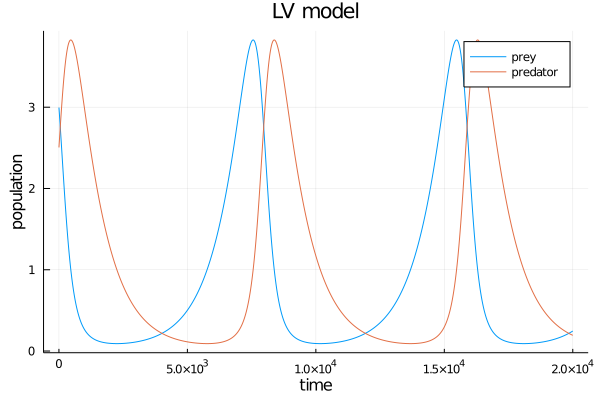

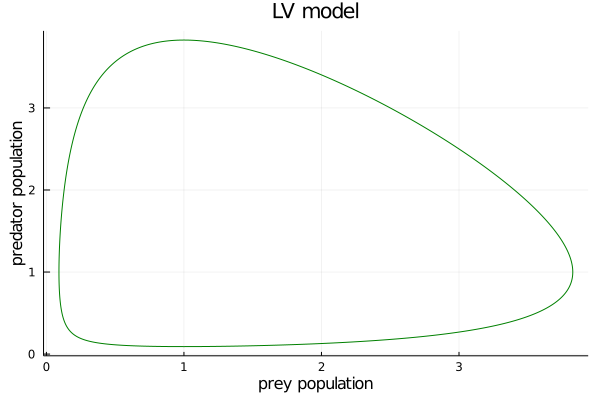

In [83]:
a = 1.0; b = 1.0; c = 1.0; d = 1.0
array = [(t, N, P) -> (N * (a - b * P)),
         (t, N, P) -> (P * (c * N - d))]

# illustrative initial values other than 0 (any 0 would simplify the model)
Y2 = [3.0, 2.5]

# solution
sol = runge_kutta_for_systems(array, 20, 0, Y2)

# plotting
p = Plots.plot(sol[:, 1], label="prey", title="LV model",
    xlabel="time", ylabel="population")
p = Plots.plot!(sol[:, 2], label="predator")
display(p)

p = Plots.plot(sol[:, 1], sol[:, 2], label=nothing, title="LV model",
    xlabel="prey population", ylabel="predator population", color=:green)
display(p)

We can clearly see how predator and prey influence each other. Big prey population causes a huge growth in predator population and when that begins to happen the prey becomes smaller as it is eaten by the predator. What follows is a decrease in predator population due to lack of foodwhich causes the prey population to breed more freely and grow.

## Realistic Lotka-Volterra [2]
We can think of the basic Lotka-Volterra relation as a simple case of given system:

$$\begin{cases} N' = F(N, P)\\ P' = G(N, P)\end{cases}$$

The change in prey population depends somehow on both prey and predator, the same applies to the change of predator population.

We will try to impove the model by working on F and G.

As for the prey in Lotka-Volterra $F(N, P) = a N - b N P$.

Since we expect prey to satisfy the logistic growth we will replace the first term with a logistic factor so in absence of predator the population doesn't explode to infinity.

The predator responds differently depending on the density of the prey, so intead of having a simple linear relation ($bN$ factor) we should consider a function $R$ that represents the reponse of predator to the density of prey.

$$ F(N, P) = N r_1(1 - \frac{N}{k}) - P \frac{A N}{N + B} $$

where $r_1$ is the growth rate of prey, $k$ is the enviromental capacity of prey.
Here we propose $R = \frac{A N}{N + B}$, where $A, B$ modify accesibility of prey to predator.

As for the predator in Lotka-Volterra $G(N, P) = - d P + c P N$.

Since the predator population is strictly connected and therefore restricted by prey population we can consider it following the logistic model.

$$ G(N, P) = P r_2(1 - \frac{P}{p N}) $$

where $r_2$ is the growth rate of predator, $p$ is the proportionality factor relating the maximum population of prey and predator.

All considered we end up with following system:

$$\begin{cases} N' = N r_1(1 - \frac{N}{k}) - P \frac{A N}{N + B}\\ P' = P r_2(1 - \frac{P}{p N})\end{cases}$$

Note that we can try to improve the Lotka-Volterra model in many ways, taking into account different assumptions and situations. We propose only one out of infinitely many solutions.

### Phase portrait

In [18]:
r_1 = 1.0; r_2 = 1.0
k = 1.0; p = 1.0
A = 1.0; B = 1.0
array = [(t, N, P) -> N * r_1 * (1 - N / k) - P * A * N / (N + B),
         (t, N, P) -> P * r_2 * (1 - P / (p * N))]

a = phase_portrait(array, 2, "RLV phase portrait", "prey population", "predator population")
save("rlv_phaseplot.png", a);

![RLV phase portrait](rlv_phaseplot.png)

We can see that in our improved model populations approach a stability point around (0.6, 0.6) (note that this depends mailny on $k$ and $p$ which describe populations capacities). We have to remember that we assumed this system is isolated. In such a case we should expect the populations to stabilize at a point where the system is in equilibrium.

The main reason for this difference between this model and basic Lotka-Volterra is the logistic factor - both populations tend to stabilize.

### Example solving
We will solve two examples of such system.

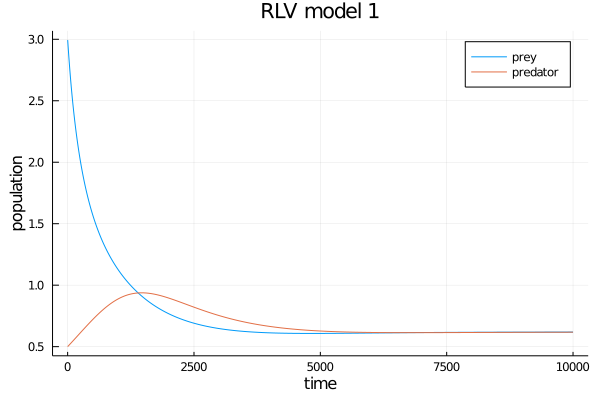

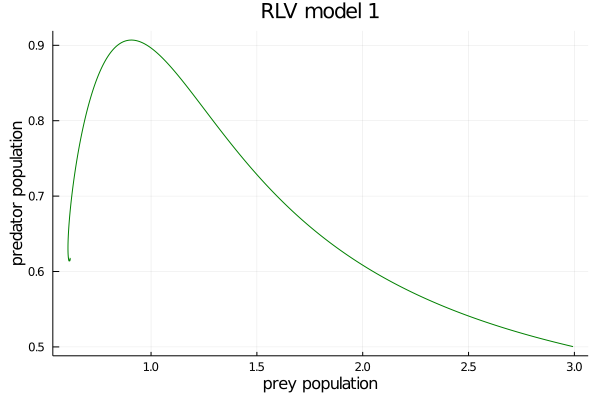

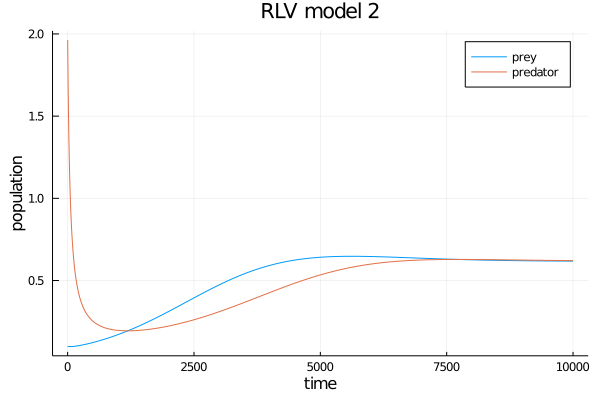

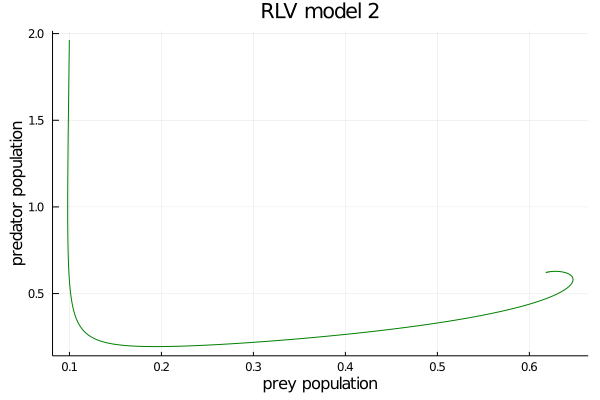

In [19]:
r_1 = 1.0; r_2 = 1.0
k = 1.0; p = 1.0
A = 1.0; B = 1.0
array = [(t, N, P) -> N * r_1 * (1 - N / k) - P * A * N / (N + B),
         (t, N, P) -> P * r_2 * (1 - P / (p * N))]

# illustrative initial values other than 0 (any 0 would simplify the model)
Y1 = [3.0, 0.5]
Y2 = [0.1, 2.0]

# solution
sol1 = runge_kutta_for_systems(array, 10, 0, Y1)
sol2 = runge_kutta_for_systems(array, 10, 0, Y2)

# plotting
p = Plots.plot(sol1[:, 1], label="prey", title="RLV model 1",
    xlabel="time", ylabel="population")
p = Plots.plot!(sol[:, 2], label="predator")
display(p)

p = Plots.plot(sol1[:, 1], sol1[:, 2], label=nothing, title="RLV model 1",
    xlabel="prey population", ylabel="predator population", color=:green)
display(p)

p = Plots.plot(sol2[:, 1], label="prey", title="RLV model 2",
    xlabel="time", ylabel="population")
p = Plots.plot!(sol2[:, 2], label="predator")
display(p)

p = Plots.plot(sol2[:, 1], sol2[:, 2], label=nothing, title="RLV model 2",
    xlabel="prey population", ylabel="predator population", color=:green)
display(p)

What was expected happened. In both sytuations the populations eventually stabilized at around (0.6, 0.6)

In the first example where the prey population was big at the start it started stabilizing (because of the logistic factor) but due to its size predator quickly started growing and lowered the prey population much below its goal. Because of that we had a lot of predator and a small number or prey. Soon the predator started dying and prey was let to breed and both of them stabilized.

In the second example the predator population was huge at the start. Because of lack of food it starte plummeting, this let the prey to breed and stabilize. The prey population growth let predator thrive and eventually both populations stabilized.

## Evaluation and analysis

For comparison we will plot real world population of Canadian lynx and Snowshoe hare. This data is frequently used as a representation of predator-prey model (mailny Lotka-Volterra), it comes from records of the numbers of pelts brought into the Hudson Bay Company. We will then conclude some characterisctics of two models discussed above.

For readability purposes the trajectory is considered for limited dataset.

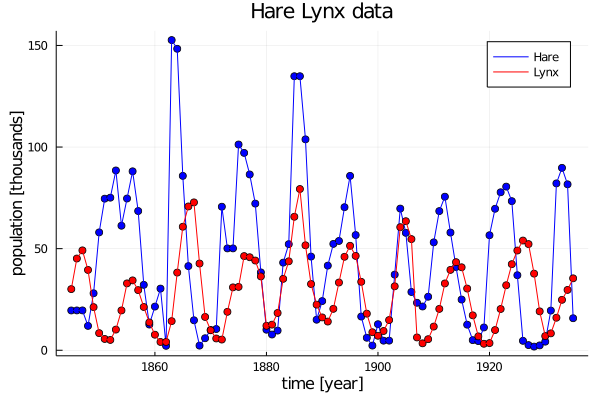

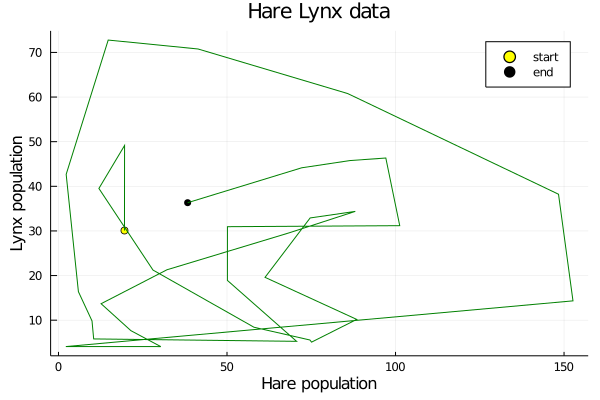

In [32]:
# loading the data
data = CSV.File("hare_lynx_data.csv") |> DataFrame;
year = data[:Year]
hare = data[:Hare]
lynx = data[:Lynx]

# plotting
p = Plots.scatter(year, hare, label=nothing, title="Hare Lynx data",
    xlabel="time [year]", ylabel="population [thousands]", color=:blue)
p = Plots.plot!(year, hare, label="Hare", color=:blue)

p = Plots.scatter!(year, lynx, label=nothing, color=:red)
p = Plots.plot!(year, lynx, label="Lynx", color=:red)
display(p)

# smaller dataset for readability
hare = hare[1:35]
lynx = lynx[1:35]

p = Plots.scatter([hare[1]], [lynx[1]], label="start", title="Hare Lynx data",
    xlabel="Hare population", ylabel="Lynx population", color=:yellow)
p = Plots.scatter!([hare[end]], [lynx[end]], label="end", title="Hare Lynx data",
    xlabel="Hare population", ylabel="Lynx population", color=:black)
p = Plots.plot!(hare, lynx, label=nothing, color="green")

display(p)

We can clearly see that both models are far from accurate, but they give us some intuition about what is happening between two species that are in this relation.

The simple L-V predicts the oscilation characteristic of this data.

Here the realistic model is unfortunately not realy realistic, it does not predict the behaviour of this system. Probably in a more isolated model we could see the stabilizing tendency. However maybe if the data was collected until this day we could see the expected behaviour.

# Mutualism

Mutualism is a kind of species interactions in which every species has benefits. 

For instance:
- bees and flowers (bees help to pollinate flowers);
- cape buffalos and red-billed oxpecker (the birds clean the skin of a buffalo from any parasites at the same time gathering food and fur for building nests).

## Model

A very naive approach would be a system like this one:

 $$ \begin{cases} y_1^{'} = \alpha_1 y_1 + \beta_1 y_1 y_2 \\ y_{2}^{'} = \alpha_2 y_2 + \beta_2 y_1 y_2\end{cases}$$
 
where constants $\alpha_1$, $\alpha_2$, $\beta_1$, $\beta_2$ are all positive. We can immediately see that this model is completely unreallistic since both species would grow infinitely.

It seems reasonable to add an environmental capacity $K$, and thus we will obtain:

$$\begin{cases} y_{1}^{'} = r_1y_1\left(1 - \frac{N_1}{K_1} + b_{12}\frac{N_2}{K_1}\right) \\ y_2^{'} = r_2y_2\left(1 - \frac{N_2}{K_2}+b_{21}\frac{N_1}{K_2}\right)\end{cases}$$

### Solving

In [85]:
nothing

## Evaluation

Blah

In [88]:
plot()
nothing

blah

# Summary

Biology and maths and statistics blah

# References

[1] [PREDATOR-PREY DYNAMICS: LOTKA-VOLTERRA](http://www.tiem.utk.edu/~gross/bioed/bealsmodules/predator-prey.html)

[2] Murray "Mathematical Biology"